### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [3]:
train_file_path = './data/lab1_train.csv'
train_data = pd.read_csv(train_file_path, delimiter=',')
train_data.columns = train_data.columns.str.strip()
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p', errors='coerce')
train_data = train_data.dropna()

test_file_path = './data/lab1_test.csv'
test_data = pd.read_csv(test_file_path, delimiter=',')
test_data.columns = test_data.columns.str.strip()
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p', errors='coerce')
test_data = test_data.dropna()

train_df_no_time = train_data.drop(columns=['Timestamp', 'Normal/Attack']).dropna()
test_df_no_time = test_data.drop(columns=['Timestamp', 'Normal/Attack']).dropna()

**Normalization**


In [4]:
train_np = train_df_no_time.values
test_np = test_df_no_time.values

train_mean = np.mean(train_np, axis=0)

train_zero_mean_np = train_np - train_mean
test_zero_mean_np = test_np - train_mean

train_zero_mean = pd.DataFrame(train_zero_mean_np, columns=train_df_no_time.columns)
test_zero_mean = pd.DataFrame(test_zero_mean_np, columns=train_df_no_time.columns)


train_std = np.std(train_np, axis=0)
train_std[train_std == 0] = 1

train_zscore_np = (train_np - train_mean) / train_std
test_zscore_np = (test_np - train_mean) / train_std

train_zscore = pd.DataFrame(train_zscore_np, columns=train_df_no_time.columns)
test_zscore = pd.DataFrame(test_zscore_np, columns=train_df_no_time.columns)

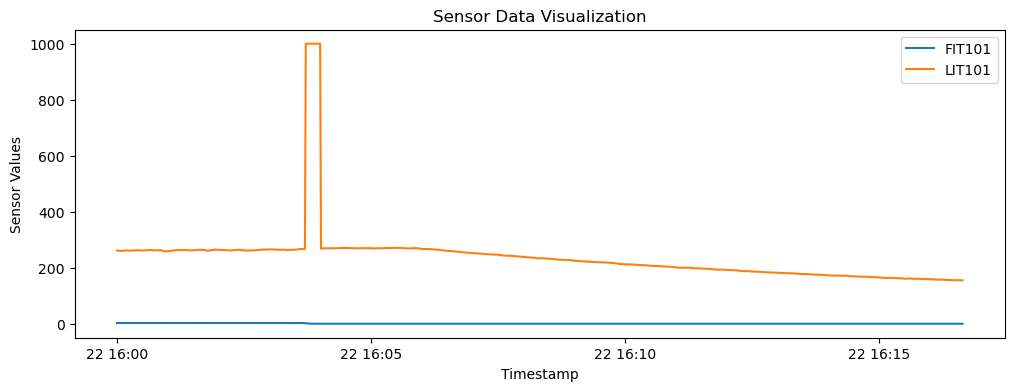

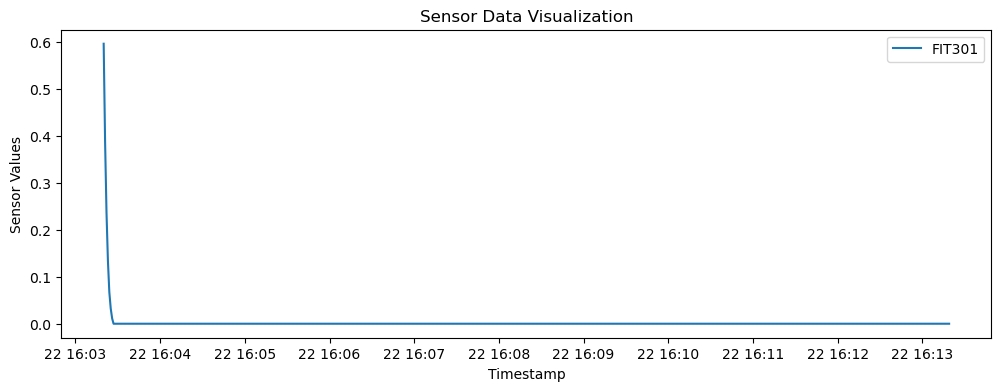

In [5]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(12, 4))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
# visualize_sensor_data(train_data)
# visualize_sensor_data(train_data, sensors=['FIT101'])
# visualize_sensor_data(train_data, sensors=['FIT101'], window=(0, 500))
# visualize_sensor_data(train_data, sensors=['LIT101'])
# visualize_sensor_data(train_data, sensors=['LIT101'], window=(0, 500))
# visualize_sensor_data(train_data, sensors=['AIT201'])
# visualize_sensor_data(train_data, sensors=['AIT201'], window=(0, 500))
# visualize_sensor_data(train_data, sensors=['PIT501'])
# visualize_sensor_data(train_data, sensors=['PIT501'], window=(0, 500))


### Familiarization

#### 1. What types of signals are there?

As the assignment specifies, the data represents different types of **SCADA signals**, representing both **continuous** and **discrete** measurements of the sensors.

**Continuous sensors:**

- **Flow sensors (FIT\*)** – measure water flow rates  
  *Examples:* FIT101, FIT201, FIT301, FIT401, FIT501, FIT502, FIT503, FIT504, FIT601

- **Level sensors (LIT\*)** – measure tank levels  
  *Examples:* LIT101, LIT301, LIT401

- **Analyzer sensors (AIT\*)** – chemical composition/quality measurements  
  *Examples:* AIT201, AIT202, AIT203, AIT401, AIT402, AIT501, 
  
- **Pressure sensors (PIT\*, DPIT\*)** – pressure or differential-pressure values  
  *Examples:* PIT501, PIT503, DPIT301

In [ ]:
def plot_sensors(df, sensors, n, m, fig_n = 16, fig_m = 8, window=None, color="C0"):
    if window is None:
        start, end = 0, len(df)
    else:
        start, end = window

    _, axs = plt.subplots(n, m, figsize=(fig_n, fig_m), sharex=True)
    axs = axs.ravel()

    for ax, sensor in zip(axs, sensors):
        ax.plot(df['Timestamp'][start:end], df[sensor][start:end], color = color)
        ax.set_title(sensor)
        ax.set_ylabel("Value")

    axs[-1].set_xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

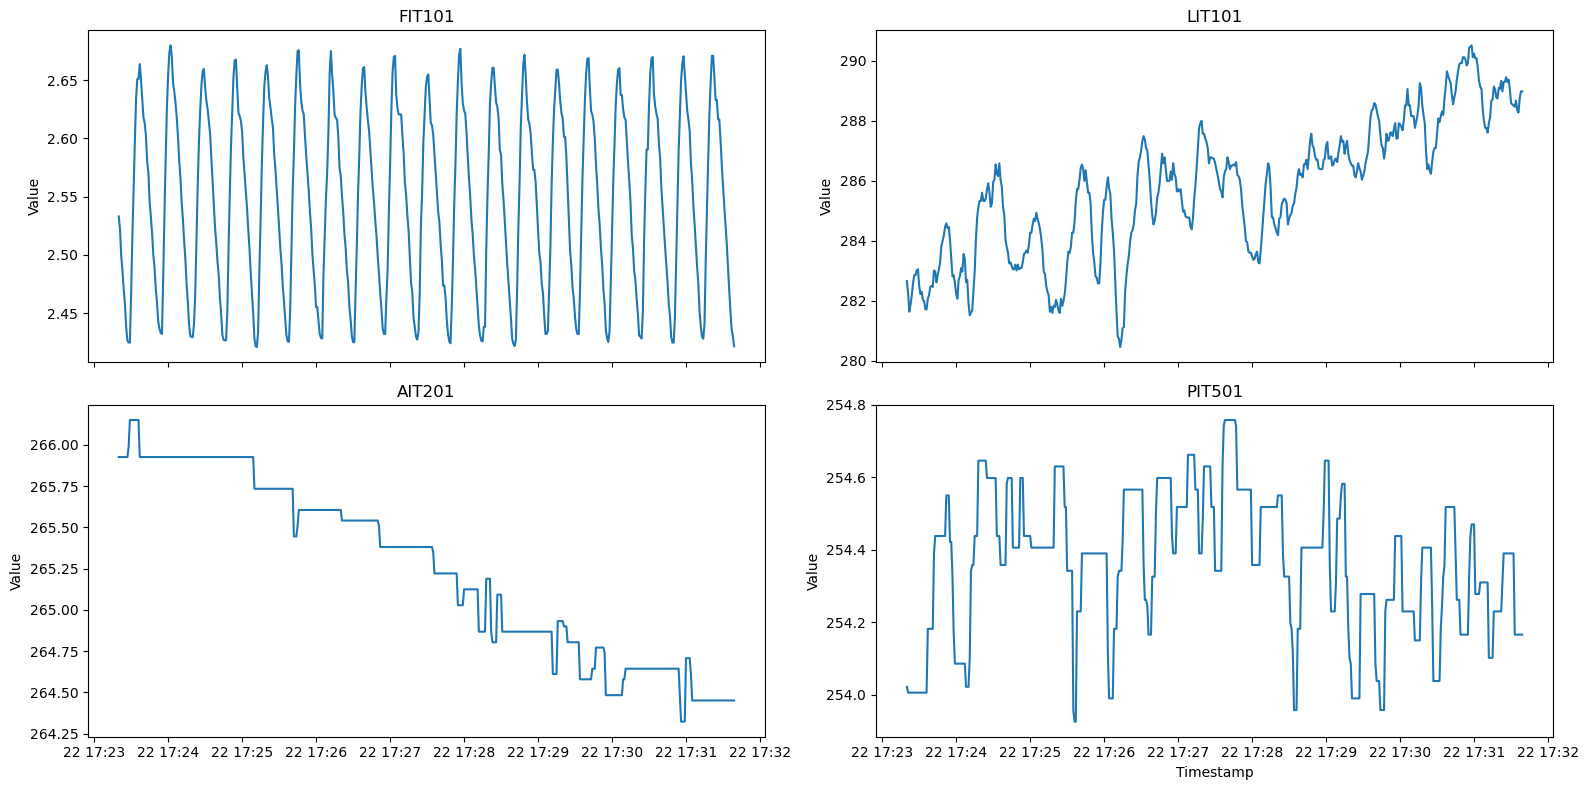

In [7]:
continuous_sensors = [
    'FIT101', 
    'LIT101',  
    'AIT201', 
    'PIT501'
]

plot_sensors(train_data, continuous_sensors, 2, 2, window=(5000, 5500))

We can also see the same pattern on the test data.

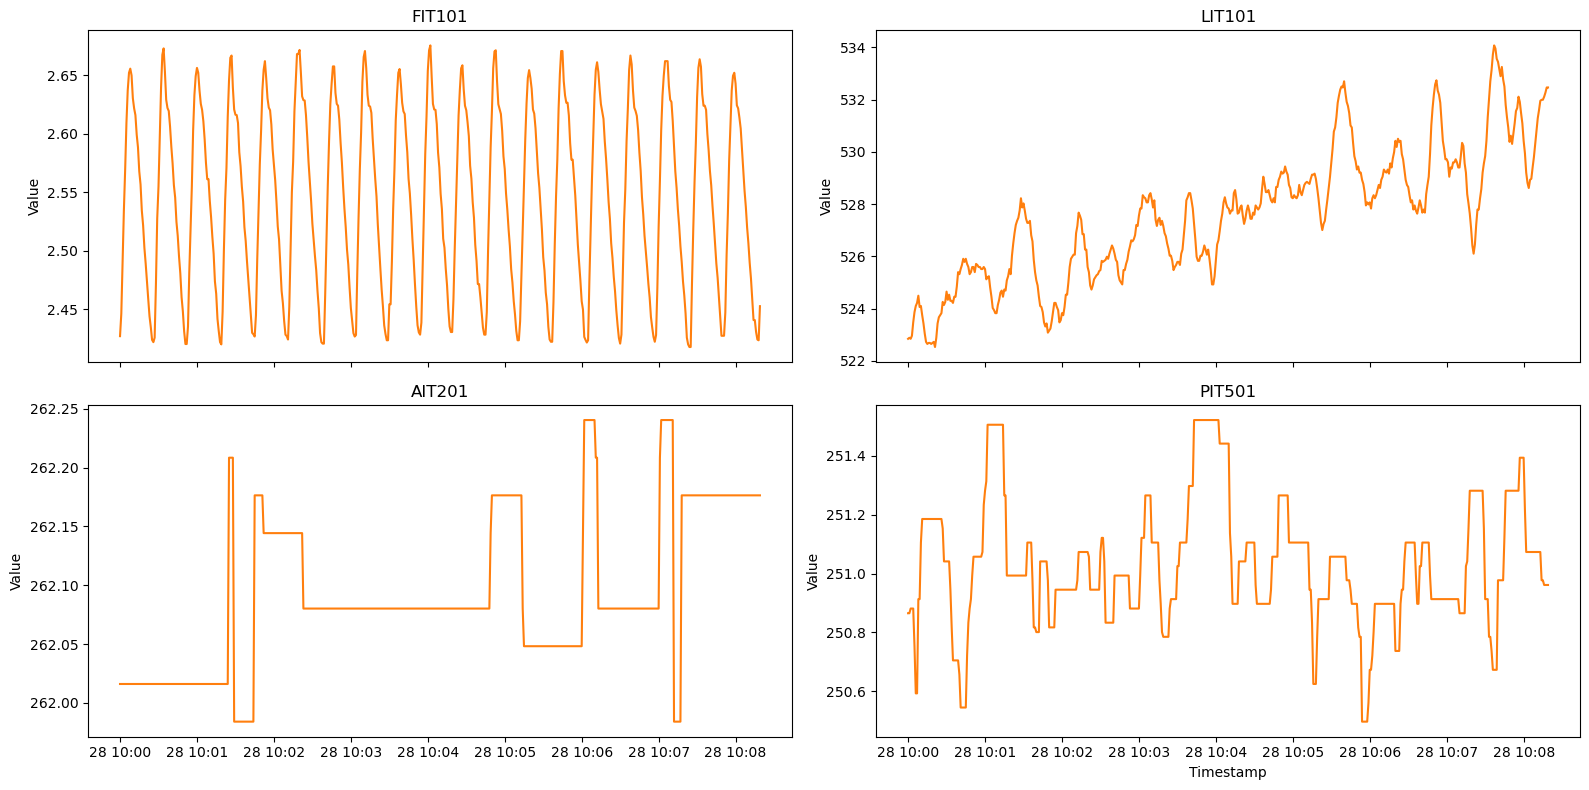

In [8]:
plot_sensors(test_data, continuous_sensors, 2, 2, window=(0, 500), color="C1")

**Discrete sensors:**

- **Motorized valves (MV\*)** – discrete states (0/1/2 for closed/open/transition)  
  *Examples:* MV101, MV201, MV301, MV304

- **Pumps (P\*)** – binary on/off signals  
  *Examples:* P101, P102, P201, P206, P301, P302, P401, P404, P501, P502, P601, P603

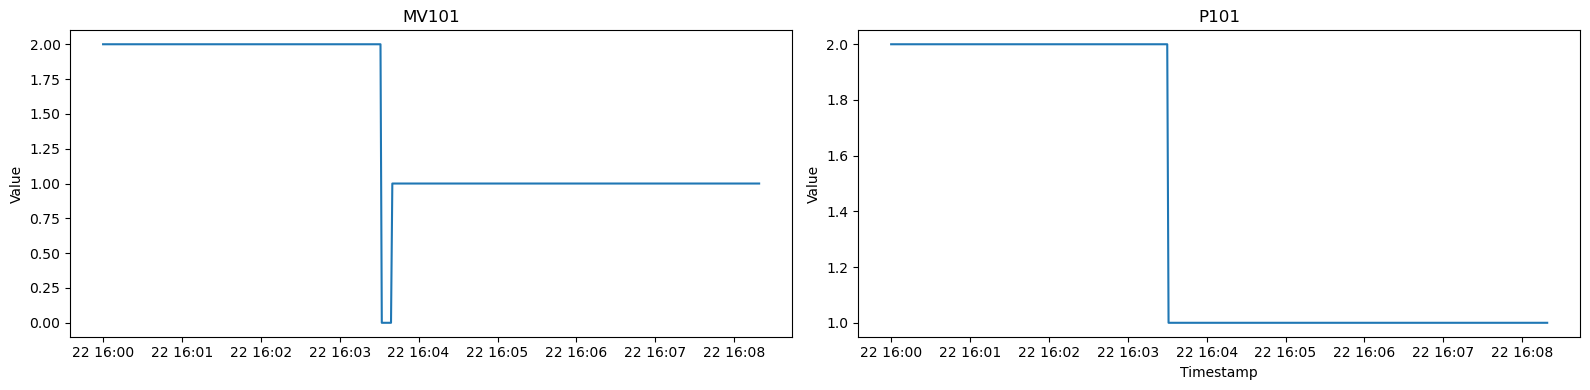

In [9]:
discrete_sensors = [
    'MV101', 
    'P101'
]

plot_sensors(train_data, discrete_sensors, 1, 2, 16, 4, window=(0, 500))


We can also see the same pattern on the test data.

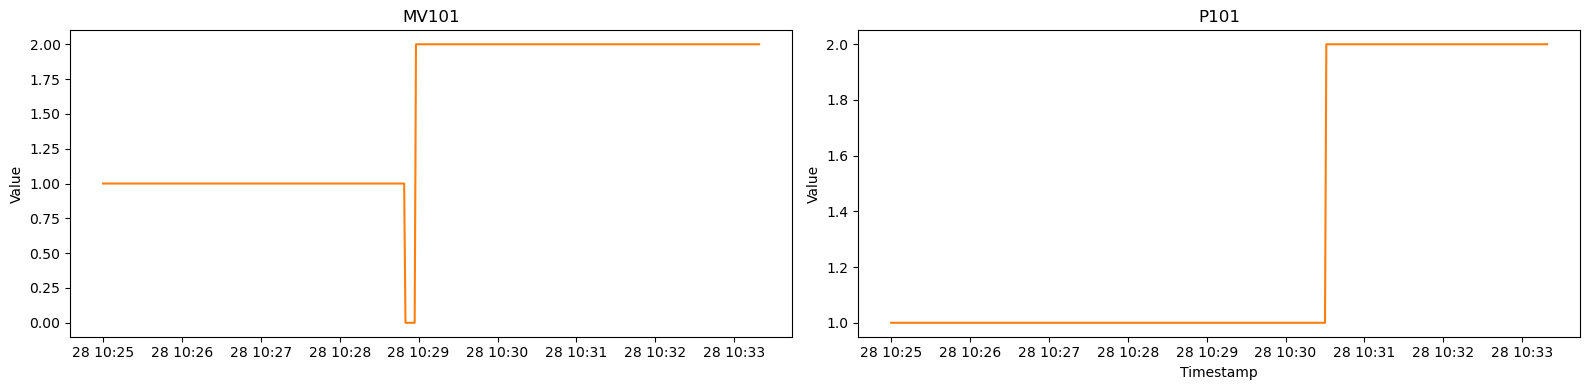

In [28]:
plot_sensors(test_data, discrete_sensors, 1, 2, 16, 4, window=(1500, 2000), color="C1")

**Label (not a sensor):**

- **Normal/Attack** – indicates whether the system is in normal operation or under attack.

#### 2. Are the signals correlated? Do they show cyclic behavior?

Based on the plots for the continous selected sensors, we observe the following:

**Cyclic behavior**
- **FIT101 (flow)** – shows regular, repeating cycles across the entire dataset. The pattern is usual for a flow cycle contolled by a valve.

- **LIT101 (tank level)** - also shows regular cycle behaviour across the entire dataset. It is less smooth than FIT101 but still periodic and synced with the flow activity. 

- **AIT201 (analyzer)** -  signal does not show cycles, it evolves gradually. 

- **PIT501 (pressure)** - shows little oscillations, but not strongly cyclic. Signal fluctuates around a stable range with small variations


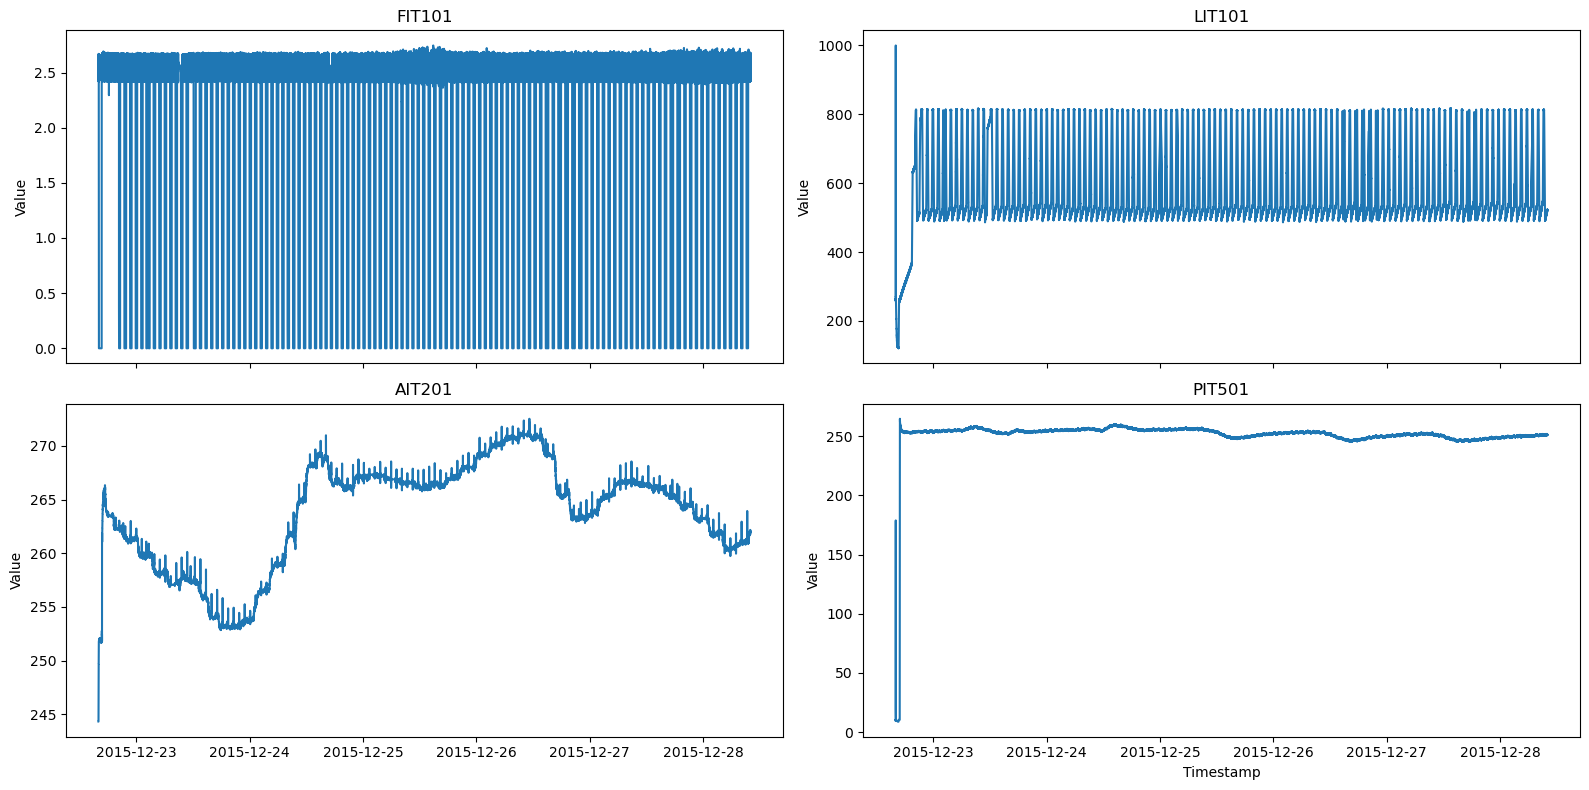

In [10]:
continuous_sensors = [
    'FIT101', 
    'LIT101',  
    'AIT201', 
    'PIT501'
]

plot_sensors(train_data, continuous_sensors, 2, 2)

**Correlation Between Signals**

Correlation analysis shows many relationships between the sensors:

- **FIT101 – LIT101**  
  Negative correlation.  
  When flow increases, the tank level may temporarily go down because of system behavior, and the other way around.

- **FIT101 – MV101**  
  Strongly positive correlation.  
  When the valve MV101 opens, the flow measured by FIT101 increases.

- **FIT5xx group**  
  Strongly positive correlation.  
  This makes sense because these flows belong to the same stage of the process.

- **AIT504 – FIT5xx group**  
  Strong negative correlation.  
  When flow rises, the chemical concentration decreases because of dilution.

- **PIT501 – FIT5xx group**  
  Strong positive correlation.  
  Higher pressure corresponds to higher flow in this subsystem.

Still, not all signals are correlated. Some sensors are basically uncorrelated:

- **AIT201 – FIT101**  
  Near-zero correlation.  
  These sensors work on different timescales and measure different things.

- **AIT201 – LIT101**  
  Near-zero correlation.  
  Their behaviors do not match in timing or shape, so correlation is almost zero.

- **AIT201 – MV101**  
  Near-zero correlation.  
  Analyzer readings do not depend on valve open/close actions.

On the correlation matrix below, you can see many more relationships between the sensors,  
red = positive correlation, blue = negative correlation, white/grey = no correlation.

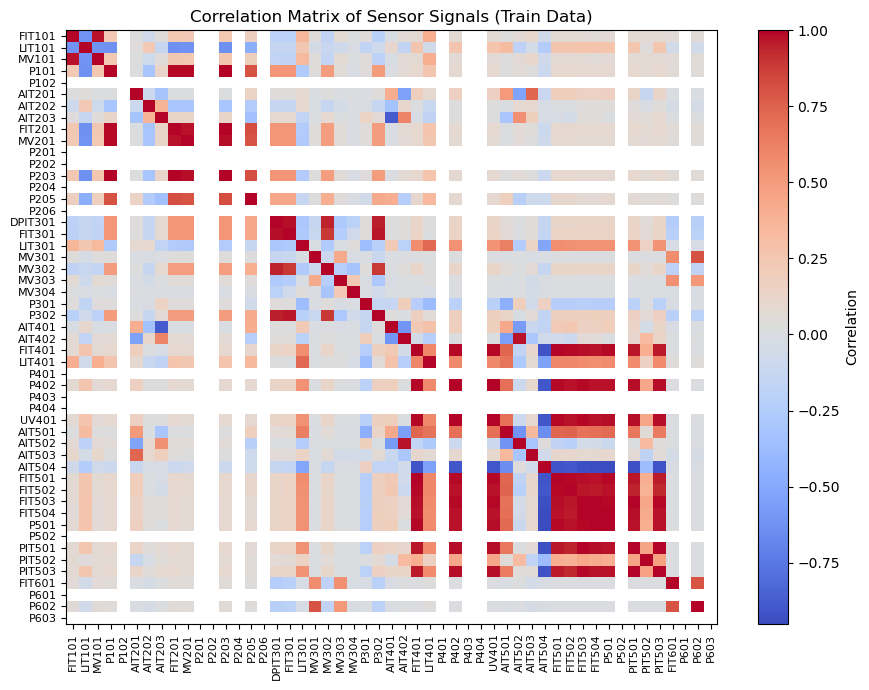

In [45]:
# We first need to compute the correlation matrix, without the Timestamp and Normal/Attack, because we are interested just in the sensors
corr = train_zscore.corr()

plt.figure(figsize=(9, 7))
plt.imshow(corr, cmap='coolwarm', aspect="auto")
plt.colorbar(label="Correlation")
plt.title("Correlation Matrix of Sensor Signals (Train Data)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8)
plt.tight_layout()
plt.show()

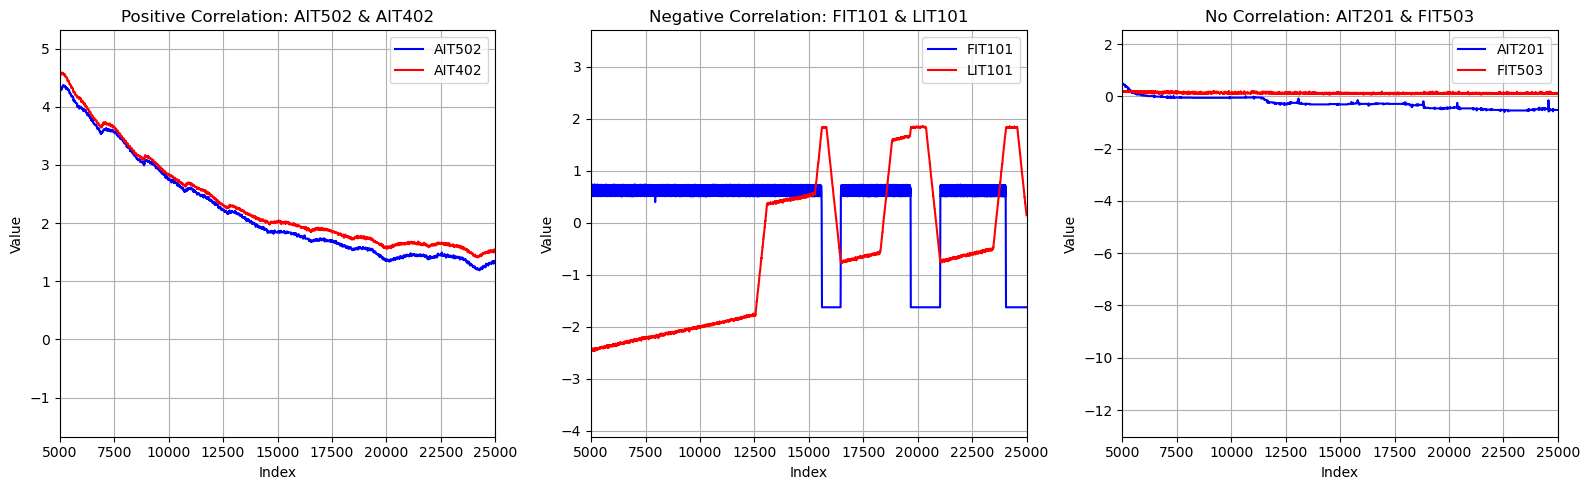

In [11]:
def correlation_graph(y1_name, y2_name, corr_type, axs):
    y1 = train_zscore[y1_name]
    y2 = train_zscore[y2_name]

    axs.plot(y1, label=y1_name, color='blue')
    axs.plot(y2, label=y2_name, color='red')

    axs.set_title(f"{corr_type} Correlation: {y1_name} & {y2_name}")
    axs.set_xlabel('Index')
    axs.set_ylabel('Value')
    axs.grid(True)
    axs.legend()
    axs.set_xlim(5000, 25000)


fig, axs = plt.subplots(1, 3, figsize=(16, 5))

correlation_graph('AIT502', 'AIT402', 'Positive', axs[0])
correlation_graph('FIT101', 'LIT101', 'Negative', axs[1])
correlation_graph('AIT201', 'FIT503', 'No', axs[2])

plt.tight_layout()
plt.show()


### PCA-based anomaly detection

We apply the PCA on mean-centered data only, to match the WebLab and also because on the lecture preprocessing file, the PCA was done with the Z-score. We are aware that the Z-score approach could increase anomaly separation, but we wanted to also do it this way. We also ask the lecturer about this and he said that it is ok to do so.

**Normalization**  
We first need to normalize the data before computing PCA
We tried to cutoff the first 15_000 points but all the threshold seemed odd after doing it. For k = 3 the training data residuals fluctuated a lot, while for the k = 4 the training residulas oscilated near the threhold, no matter how high we setted it. Also for k > 4, all the models overfitted and raised a lot of false alarms, so we decided to keep the startup in other to add a little bit of noise for the model.

In [ ]:
CUTOFF = 0

X_train_centered = train_zero_mean_np[CUTOFF:]
X_test_centered = test_zero_mean_np[CUTOFF:]

**Fit PCA**  
We fit PCA on the centered training data

In [13]:
n_samples = X_train_centered.shape[0]
cov_matrix = (X_train_centered.T @ X_train_centered) / (n_samples - 1)

eigvals, eigvecs = np.linalg.eigh(cov_matrix)

idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

We choose an initial small number of principal components, k = 2 for inspection. Later we will evaluate multiple values of k.

**Data projection**

In [14]:
k = 2 

W_k = eigvecs[:, :k]

Z_train = X_train_centered @ W_k 
Z_test = X_test_centered  @ W_k

We now project both the centered training data and the centered test data onto the first two principal components (PC1 and PC2). The visualization allows us to see how the structure of the test set differs from normal behavior learned from the training set.

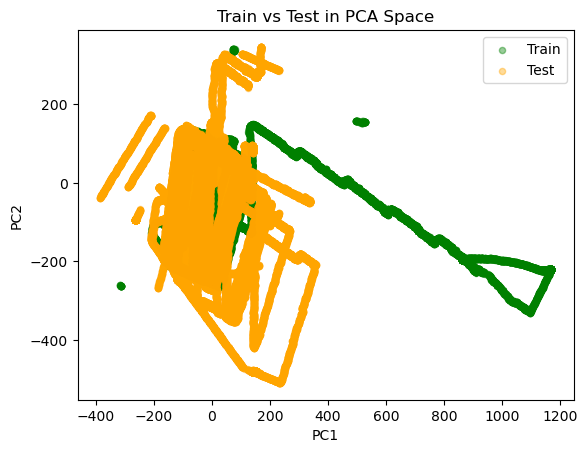

In [179]:
train_pca = pd.DataFrame(Z_train, columns=['PC1', 'PC2'])
test_pca = pd.DataFrame(Z_test, columns=['PC1', 'PC2'])

ax = train_pca.plot.scatter(x='PC1', y='PC2', color='green', alpha=0.4, label='Train')
test_pca.plot.scatter(x='PC1', y='PC2', color='orange', alpha=0.4, label='Test', ax=ax)
plt.title('Train vs Test in PCA Space')
plt.show()

**Compute explained variance**

In [15]:
explained_variance = eigvals / eigvals.sum()
cumulative_explained = np.cumsum(explained_variance)

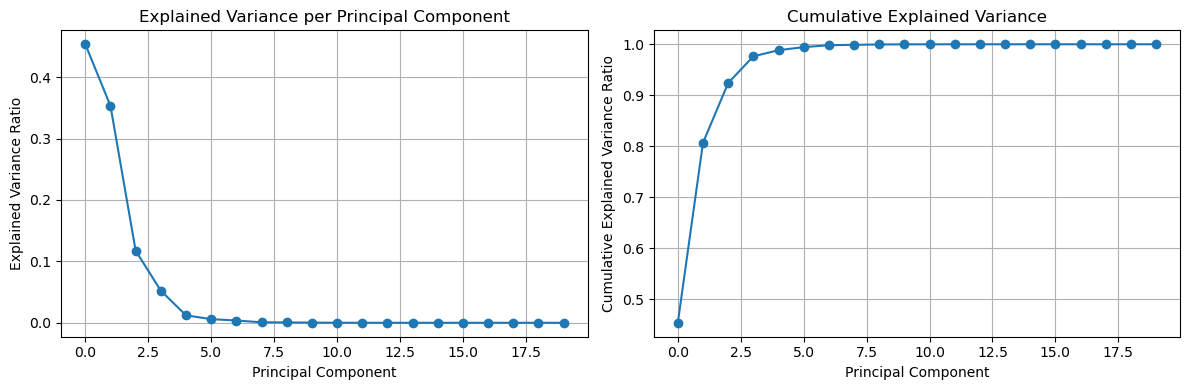

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(explained_variance[:20], marker='o')
axs[0].set_title("Explained Variance per Principal Component")
axs[0].set_xlabel("Principal Component")
axs[0].set_ylabel("Explained Variance Ratio")
axs[0].grid(True)

axs[1].plot(cumulative_explained[0:20], marker='o')
axs[1].set_title("Cumulative Explained Variance")
axs[1].set_xlabel("Principal Component")
axs[1].set_ylabel("Cumulative Explained Variance Ratio")
axs[1].grid(True)

plt.tight_layout()
plt.show()

**PCA Reconstruction**

In [17]:
X_train_recon_centered = Z_train @ W_k.T
X_test_recon_centered = Z_test @ W_k.T

**Residuls Calculation**

Residuals show how well PCA captures each data point.  
Points with unusually large reconstruction error may be anomalies or abnormal events.

For the anomaly score, we will use the L2 reconstruction error, as recommended in the lecture.

In [18]:
train_residuals = np.linalg.norm(X_train_centered - X_train_recon_centered, axis=1)
test_residuals = np.linalg.norm(X_test_centered - X_test_recon_centered,  axis=1)

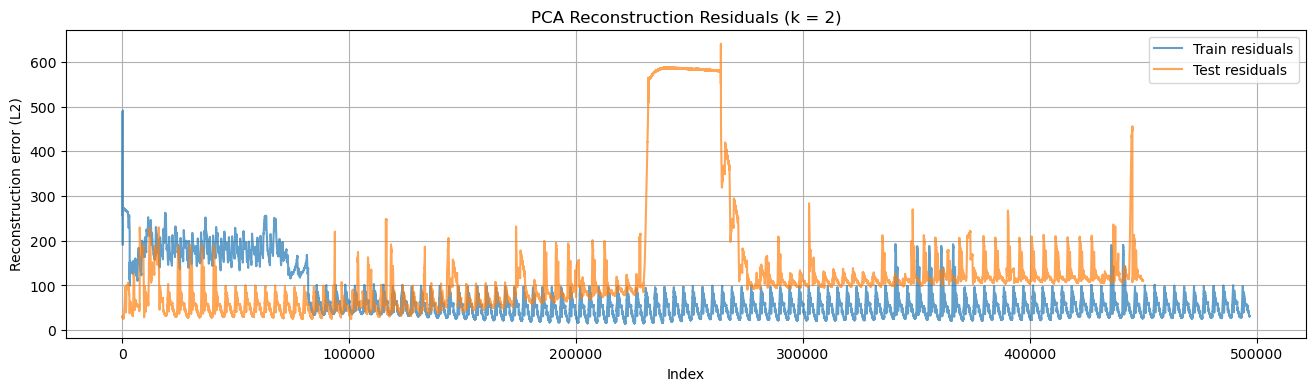

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(train_residuals, label='Train residuals', alpha=0.7)
plt.plot(test_residuals,  label='Test residuals',  alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Reconstruction error (L2)')
plt.title('PCA Reconstruction Residuals (k = 2)')
plt.legend()
plt.grid(True)
plt.show()

**Do you see large abnormalities in the training data?**  
Yes. In the training residuals, a large spike appears at the very beginning of the dataset. This does not correspond to an attack, but to the startup transient of the SCADA system.  

**Can you explain why these occur?**   
During startup, pumps switch on, tanks begin to fill, flows and pressures stabilize, and the physical relationships between sensors are temporarily very different from the normal operation. PCA is trained on normal behaviour correlations, so it cannot reconstruct these startup points well, which leads to a very high residual. After this initial transient, the training residuals remain low and stable, indicating normal behavior.

**It is best to remove such abnormalities from the training data since you only want to model normal behavior?**  
 Yes, it is. If we keep this startup points in the training set, the PCA model will not model a constant behaviour anymore. The mean and standard varianes will be disrupted but the unusual points in the begining and it will be hard for PCA to make the difference between an anomaly and a normal state. Removing the startup region before fitting PCA gives a cleaner model of normal operation and improves anomaly sensitivity. (In theory, but we keep them in other to have some noise for an easier place of the threshold)

**Describe the kind of anomalies you expect to detect using PCA.**  
 PCA detects multivariate anomalies, meaning situations where several sensors behave in a way that does not match the normal relationships between them. Even if each individual sensor looks normal, the combination of their values can be unusual. PCA is good at finding abnormal behaviours, strange changes across multiple sensors or attacks that affect more parts at once.

**Choosing the Number of Components**  
To determine the appropriate number of components, we compute the reconstruction residuals on the training data for multiple values of k and plot them together.

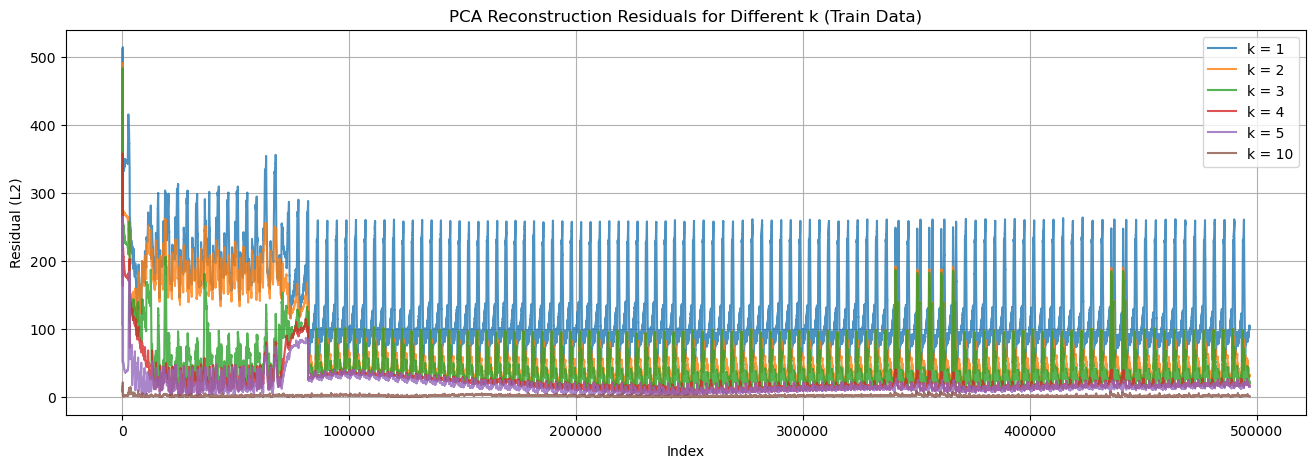

In [20]:
ks = [1, 2, 3, 4, 5, 10]
plt.figure(figsize=(16, 5))

for k_test in ks:
    W_k_test = eigvecs[:, :k_test]
    
    Z_train_k = X_train_centered @ W_k_test
    X_train_recon_k = Z_train_k @ W_k_test.T
    
    res_k = np.linalg.norm(X_train_centered - X_train_recon_k, axis=1)
    
    plt.plot(res_k, label=f'k = {k_test}', alpha=0.8)

plt.title("PCA Reconstruction Residuals for Different k (Train Data)")
plt.xlabel("Index")
plt.ylabel("Residual (L2)")
plt.legend()
plt.grid(True)
plt.show()


From the k plot we see that for small k (e.g., k = 1–2) the reconstruction error on the training data is very high. This means PCA underfits and would produce many false alarms. As k increases, the residuals on the training data decrease significantly and become stable. Around k = 4-7 the curve flattens out, meaning that adding more components provides almost no additional improvement.

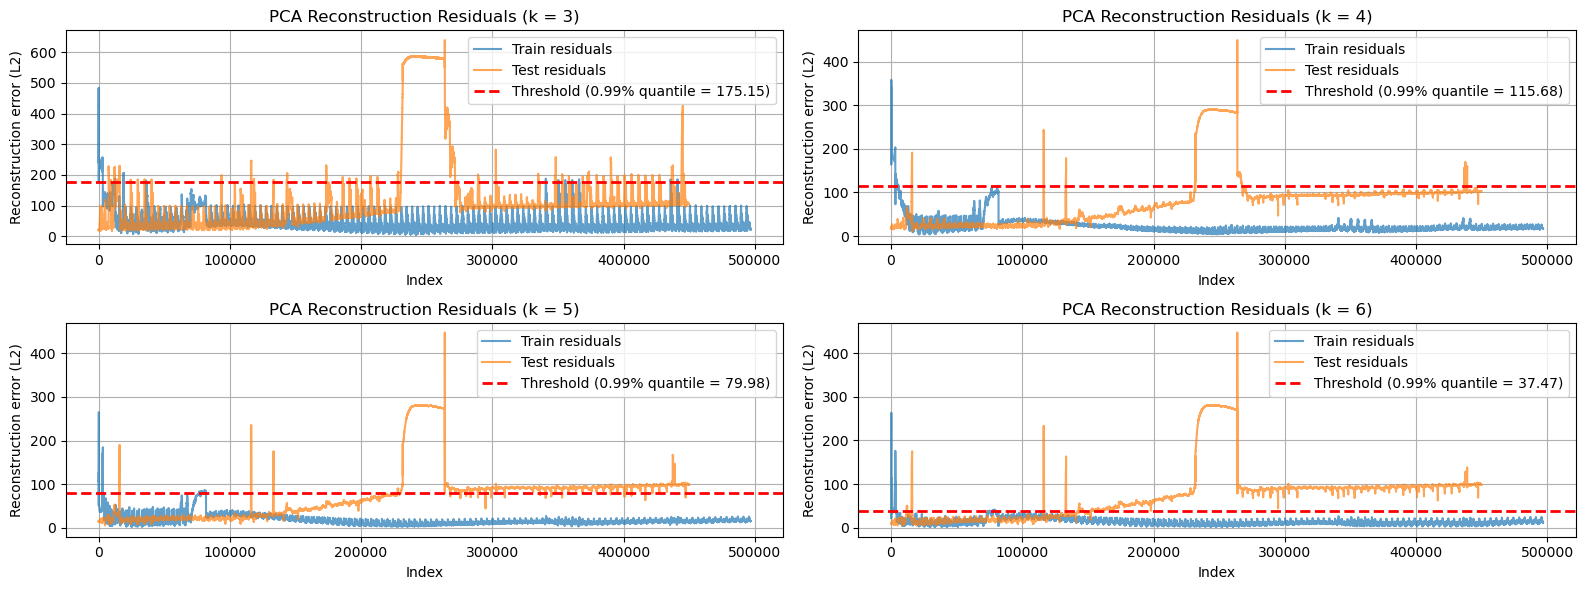

In [24]:
ks = [3, 4, 5, 6]

def residual_graph(train_res_k, test_res_k, k, quantile, axs):
    axs.plot(train_res_k, label='Train residuals', alpha=0.7)
    axs.plot(test_res_k, label='Test residuals',  alpha=0.7)   

    threshold = round(np.quantile(train_res_test, quantile), 2)

    axs.axhline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({quantile}% quantile = {threshold})')

    axs.set_title(f'PCA Reconstruction Residuals (k = {k})')
    axs.set_xlabel('Index')
    axs.set_ylabel('Reconstruction error (L2)')
    axs.grid(True)
    axs.legend()

fig, axs = plt.subplots(2, 2, figsize=(16, 6))
axs = axs.ravel()

for i, k_test in enumerate(ks):
    W_test= eigvecs[:, :k_test]

    Z_train_test = X_train_centered @ W_test
    Z_test_test = X_test_centered  @ W_test

    X_train_recon_test = Z_train_test @ W_test.T
    X_test_recon_test = Z_test_test  @ W_test.T

    train_res_test = np.linalg.norm(X_train_centered - X_train_recon_test, axis=1)
    test_res_test = np.linalg.norm(X_test_centered - X_test_recon_test, axis=1)

    quantile = 0.99
    residual_graph(train_res_test, test_res_test, k_test, quantile, axs[i])

plt.tight_layout()
plt.show()

k = 3  
  Captures too little variance (~92%), causing large reconstruction errors for both training and test sets.  
  The threshold becomes very high (~175), making the detector too permissive.  
  The residual plot looks unstable and irregular, with unusually large fluctuations compared to higher-k models.  
_Rejected: unstable residual pattern + underfitting._  

k = 4  
  Captures a strong amount of variance (~97%) and stabilizes the reconstruction error.  
  The threshold (~115) sits at a reasonable level, high enough to avoid false alarms but low enough to detect major anomalies.  
  Normal behaviour on the right side of the test data remains below the threshold and significantly fewer false positives compared to k = 5 or 6.  
_Chosen: best balance between sensitivity and reliability._  
  
k = 5  
  Although it captures ~99% variance, the threshold drops to 80, which is more aggressive.  
  This thehold causes the right part of the test data to lie under the line.  
  This produces a noticeable number of false positives that do not correspond to visually abnormal behaviour.  
_Rejected: too many false alarms on the right side._  

k = 6  
  Threshold becomes very low (~37), making the model extremely sensitive.  
  All the points over 12.000 (over 70%) are consider anomalies.   
  Clear signs of overfitting (residuals for train are extremely low for all the points over 500).  
_Rejected: severe over-detection of anomalies._  

**Final Selection of the Number of Components**  
Based on the comparison of residuals for k = 3, 4, 5, 6, we select **k = 4** as the optimal number of principal components.   

For smaller values (k = 1–3), the reconstruction error on the training data remains high, and the residual plots look unstable and irregular. This indicates underfitting because the model does not capture enough of the normal correlation structure.  

For k = 5 and above, the threshold becomes increasingly strict. This leads to many oscilations in the right side of the test data, being incorrectly flagged as anomalies, which significantly increases the rate of false positives.  

With k = 4, the reconstruction error on the training set is stable, the threshold remains at a reasonable level, and the method avoids the false alarms that appear for larger k values. Major anomalies, including the strong abnormal region around index 250,000, remain well above the threshold. This provides the best balance between accurate detection and operational stability.

**Expectation**  
Using PCA with k = 4, we expect to detect periods where the correlations between sensors that deviate from the normal behavior.   
PCA is sensitive to changes across several sensors, making it perfect for detecting process faults, system attacks, or not-normal operating regions.  
We also expect very few false alarms, since the chosen k reconstructs normal behavior with low residuals.

### DTW-based anomaly detection

For the DTW, we need a sensor that shows clear temporal behaviour, meaning that it should change over time, have a structured pattern, and not remain flat or random.

From our point of view, **F101** makes a perfect candidate because at has all these features. It has a repeating cyclic pattern during normal operation, with rises and drops that form a stable shape over time. This makes it suitable for DTW, because DTW can align and compare these cycles.

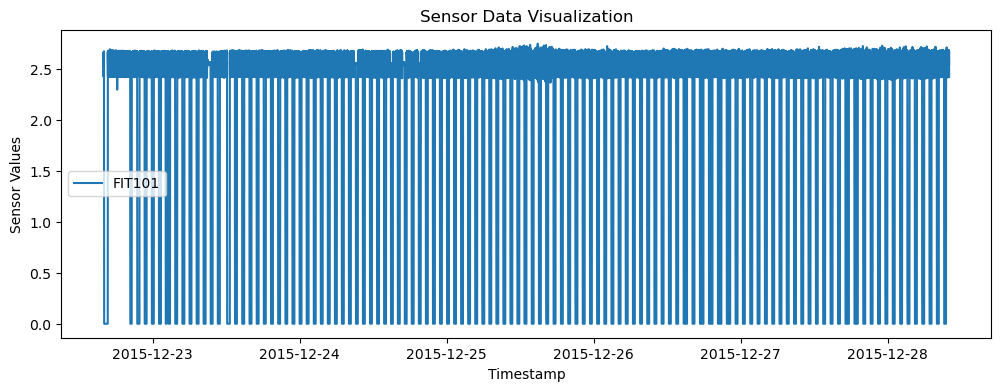

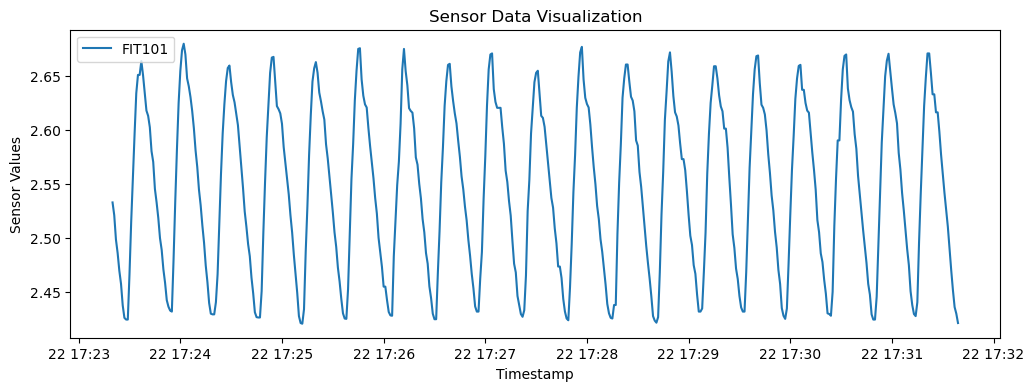

In [6]:
visualize_sensor_data(train_data, sensors=['FIT101'])
visualize_sensor_data(train_data, sensors=['FIT101'], window=(5000, 5500))

**Normalizing data step**  
The first step told in the lecture was that we need to normalize data for this algorithm

In [7]:
signal = "FIT101"

fit101_train_raw = train_df_no_time[signal].values
fit101_test_raw  = test_df_no_time[signal].values

fit_mean = np.mean(fit101_train_raw)

fit101_train = fit101_train_raw - fit_mean
fit101_test = fit101_test_raw - fit_mean

**Representative Windows**  
We used a window size of 200 samples.  
This length captures several rising and falling cycles of FIT101, so each window can represents a segment of normal behaviour.

In [8]:
def build_windows(sensor, window_size, stride):
    train_windows = []
    for i in range(0, len(sensor) - window_size, stride):
        window = sensor[i : i + window_size]
        train_windows.append(window)
    return np.array(train_windows)

WINDOW_SIZE = 200
STRIDE = 50

train_windows = build_windows(fit101_train, WINDOW_SIZE, STRIDE)

We tried to use all windows and even 1 in 5 as DTW references but unfortunately is was too slow, because each test window would have to be compared to all of them.  
To keep the run-time manageable, we selected 20 representative windows, evenly spaced across the whole training period.   
We think that this also keeps good coverage of the normal behaviour and still validates the scope of this lab of idendifing abnormal data. (and the program runned 30 minutes for 100 representatives and did not finish)

In [9]:
def pick_representatives(windows, n_rep):
    num_windows = windows.shape[0]
    rep_idx = np.linspace(0, num_windows - 1, n_rep, dtype=int)
    return windows[rep_idx]

N_REPRESENTATIVE = 20
num_windows = train_windows.shape[0]
rep_windows = pick_representatives(train_windows, N_REPRESENTATIVE)

print("Total windows:", num_windows)
print("Representative windows:", rep_windows.shape[0])

Total windows: 9932
Representative windows: 20


**Plot of the windows**  
The plot shows the first two representative windows taken from the FIT101 training signal. Each window contains one cycle of the flow pattern, and represents what the algorithm considers “normal” behaviour.

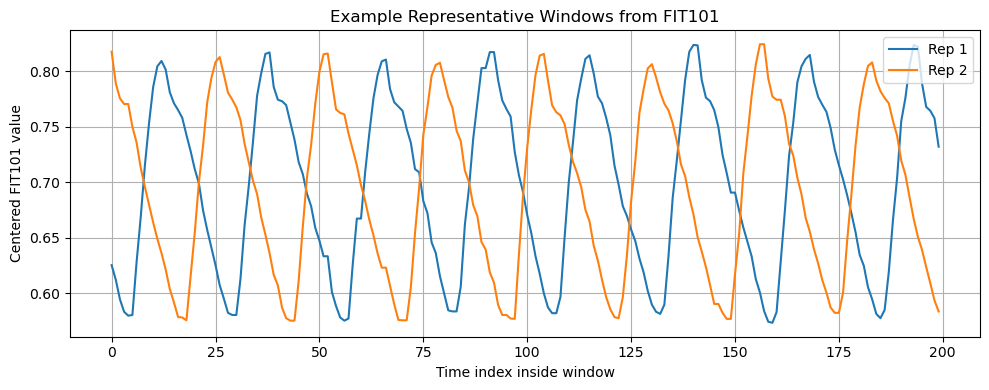

In [10]:
plt.figure(figsize=(10, 4))

for i in range(2): 
    plt.plot(rep_windows[i], label=f"Rep {i+1}")

plt.title("Example Representative Windows from FIT101")
plt.xlabel("Time index inside window")
plt.ylabel("Centered FIT101 value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**DTW algorithm**  
This is the dynamic time warping algorithm extracted from Weblab.

In [11]:
def euclidean(x, y):
    return (x - y) ** 2

def dynamic_time_warping(a, b):
    n = a.size
    m = b.size
    
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    dtw = np.full((n, m), np.inf, dtype=float)
    dtw[0, 0] = euclidean(a[0], b[0])

    for i in range(1, n):
        dtw[i, 0] = euclidean(a[i], b[0]) + dtw[i-1, 0]

    for j in range(1, m):
        dtw[0, j] = euclidean(a[0], b[j]) + dtw[0, j-1]

    for i in range(1, n):
        for j in range(1, m):
            cost = euclidean(a[i], b[j])
            dtw[i, j] = cost + min(
                dtw[i-1, j], 
                dtw[i, j-1], 
                dtw[i-1, j-1]
            )

    return np.sqrt(dtw[n-1, m-1])

When computing DTW residuals, each evaluation window must be compared to every representative window. This is expensive because DTW fills an entire cost matrix for every comparison.    
To keep the computation feasible, we used a large stride of 2000 samples when building the evaluation windows. This greatly reduces the number of evaluations while still covering the full test signal at regular intervals.   
The goal was to balance runtime and detection ability. With stride = 2000 (even if the number seems enormous) the algorithm finishes in reasonable time and still identifies clear deviations in the signal.

In [12]:
STRIDE = 2000

def build_eval_windows(data, window_size, stride):
    eval_windows = []
    centers = []

    for start in range(0, len(data) - window_size + 1, stride):
        end = start + window_size
        eval_windows.append(data[start:end])
        centers.append(start + window_size // 2) 

    return np.array(eval_windows), np.array(centers)

train_eval_windows, train_centers = build_eval_windows(fit101_train, WINDOW_SIZE, STRIDE)
test_eval_windows, test_centers = build_eval_windows(fit101_test, WINDOW_SIZE, STRIDE)

In [13]:
def compute_dtw_residuals(eval_windows, rep_windows):
    n = eval_windows.shape[0]
    residuals = np.zeros(n)

    for i in range(n):
        w = eval_windows[i]
        dists = [dynamic_time_warping(w, rep) for rep in rep_windows]
        residuals[i] = min(dists)

    return residuals

In [50]:
# This would take a lot of time to run
train_residuals = compute_dtw_residuals(train_eval_windows, rep_windows)
test_residuals = compute_dtw_residuals(test_eval_windows, rep_windows)

**What kind of anomalies do you expect to detect using DTW distances?**  
With DTW distance, we want to detect local shape anomalies. Since DTW has windows that represent "normal" behaviour, that means that if the distance from a window to the most similar representative is big, that portion of the signal is an anomaly.  

What is it that we expect to see:  
- Sudden changes in the signal shape, such as sharp drops, spikes, or unusual shapes
- Weird cycles where the rising or falling pattern of FIT101 does not follow the normal shape.
- Short unusual behaviours that do not match any normal window


**Plots**

In [14]:
def plot_residuals(train_centers, train_residuals, test_centers, test_residuals, quantile):
    plt.figure(figsize=(14, 5))

    plt.plot(train_centers, train_residuals, label="Train residuals")
    plt.plot(test_centers,  test_residuals,  label="Test residuals")

    threshold = np.quantile(train_residuals, quantile)

    plt.axhline(threshold, color="red", linestyle="--",
                label=f"Threshold ({quantile}% train = {threshold:.2f})")

    plt.xlabel("Time index")
    plt.ylabel("DTW distance to nearest normal window")
    plt.title("DTW Residuals for FIT101 with Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()

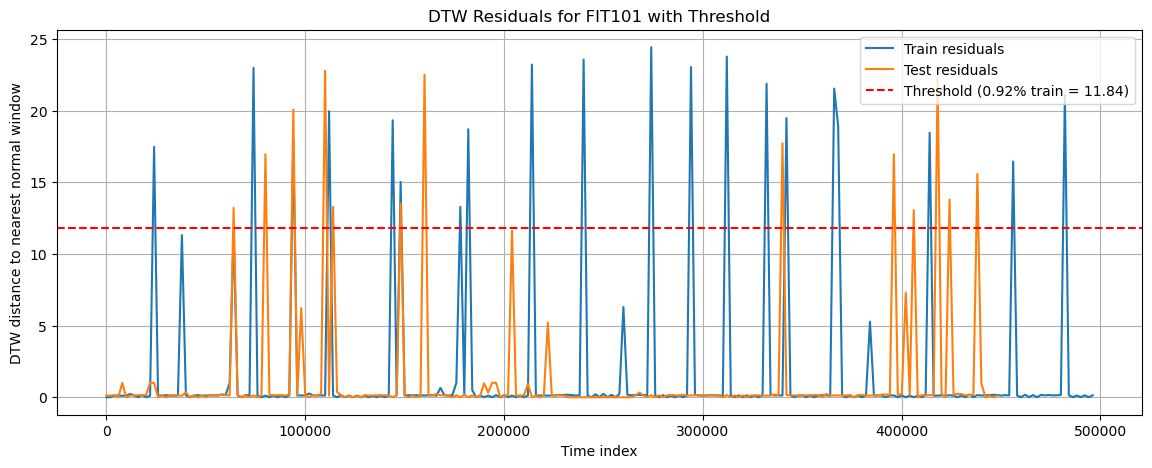

In [38]:
quantile = 0.92
plot_residuals(train_centers, train_residuals, test_centers, test_residuals, quantile)

This plot shows the DTW residuals for all evaluation windows in the training and test sets.  
The threshold separates normal variation from unusually large distances. Large spikes indicate windows whose shape does not match any normal representative cycle.  
The test set contains several such spikes, which correspond to abnormal local patterns in the signal.

In [15]:
def plot_signal_and_residuals(test_signal, test_centers, test_residuals, train_residuals, quantile):
    test_residuals_series = pd.Series(test_residuals, index=test_centers)
    x_range = [0, len(test_signal)]

    _, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(test_signal, label="FIT101 (test)", color='blue')
    axes[0].set_title("Signal: FIT101 (test)")
    axes[0].set_ylabel("Centered FIT101 value")
    axes[0].set_xlim(x_range[0], x_range[1])
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(test_residuals_series, label="DTW residual", color='red')
    threshold = np.quantile(train_residuals, quantile)
    axes[1].axhline(threshold, color="orange", linestyle="--",
                    label=f"Threshold ({quantile}% train = {threshold:.2f})")
    axes[1].set_title("DTW Residuals for FIT101 (Test)")
    axes[1].set_xlabel("Time index (window centers)")
    axes[1].set_ylabel("Residual magnitude")
    axes[1].set_xlim(x_range[0], x_range[1])
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

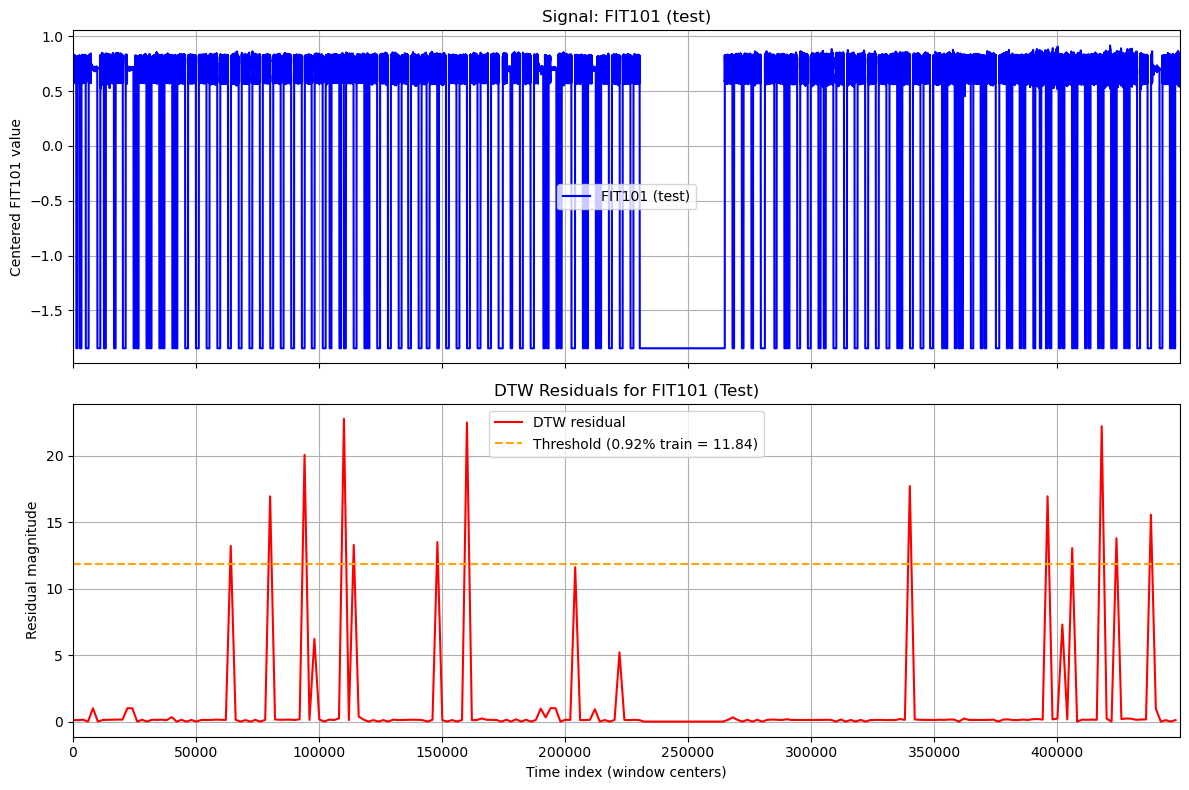

In [53]:
quantile = 0.92
plot_signal_and_residuals(fit101_test, test_centers, test_residuals, train_residuals, quantile)

This figure aligns the test signal (top) with the DTW residuals at the corresponding window centers (bottom).  
DTW reacts to shape changes (sharp transitions, distorted cycles), which appear as tall peaks in the residual plot.  
The long "low flow" attack in the middle is not caught by DTW, because each small window inside this flat region looks similar to the normal low part of a cycle.  
Thus, with short windows, DTW mainly detects local shape anomalies rather than long-duration deviations.  

**Experiment with using different sliding window**

In [16]:
def run_dtw_experiment(fit_train, fit_test,
                       window_size, train_stride, eval_stride,
                       n_rep=20, quantile=0.95):

    train_windows_exp = build_windows(fit_train, window_size, train_stride)
    rep_windows_exp = pick_representatives(train_windows_exp, n_rep)

    train_eval_exp, train_centers_exp = build_eval_windows(fit_train, window_size, eval_stride)
    test_eval_exp, test_centers_exp = build_eval_windows(fit_test, window_size, eval_stride)


    train_res_exp = compute_dtw_residuals(train_eval_exp, rep_windows_exp)
    test_res_exp = compute_dtw_residuals(test_eval_exp, rep_windows_exp)
    
    plot_residuals(train_centers_exp, train_res_exp, test_centers_exp, test_res_exp, quantile)

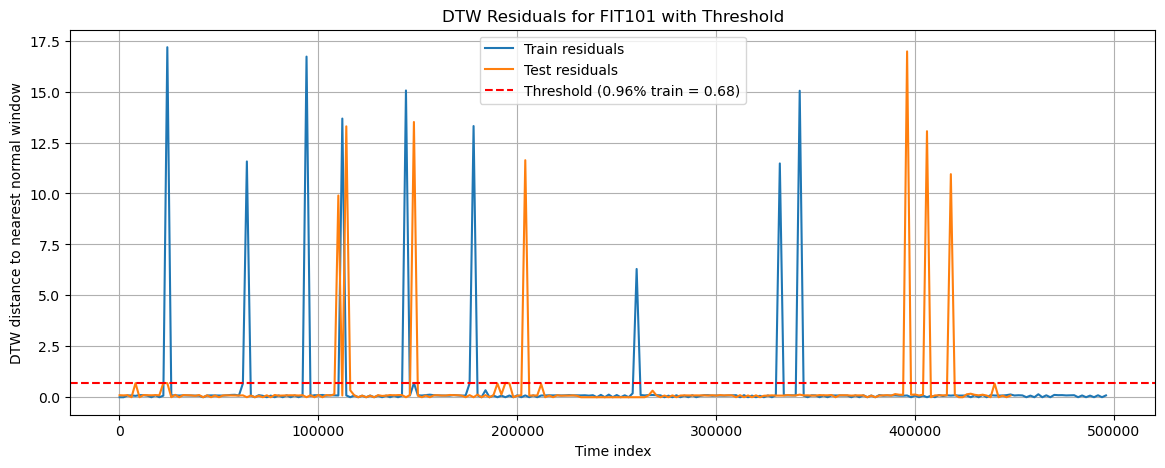

In [17]:
signal = "FIT101"

run_dtw_experiment(
    fit101_train, fit101_test,
    window_size=100,
    train_stride=50,
    eval_stride=2000,
    n_rep=20,
    quantile=0.96,
)

The DTW residuals for both train and test are very close to zero during normal behaviour, with only a few sharp peaks.  
The threshold sits well above the normal residual level and is only exceeded by a small number of windows.  
It looks like a good separation between normal and abnormal, still, we think that the window size is too low.  
The anomoly between 22_000 and 27_000 is still not caught. 

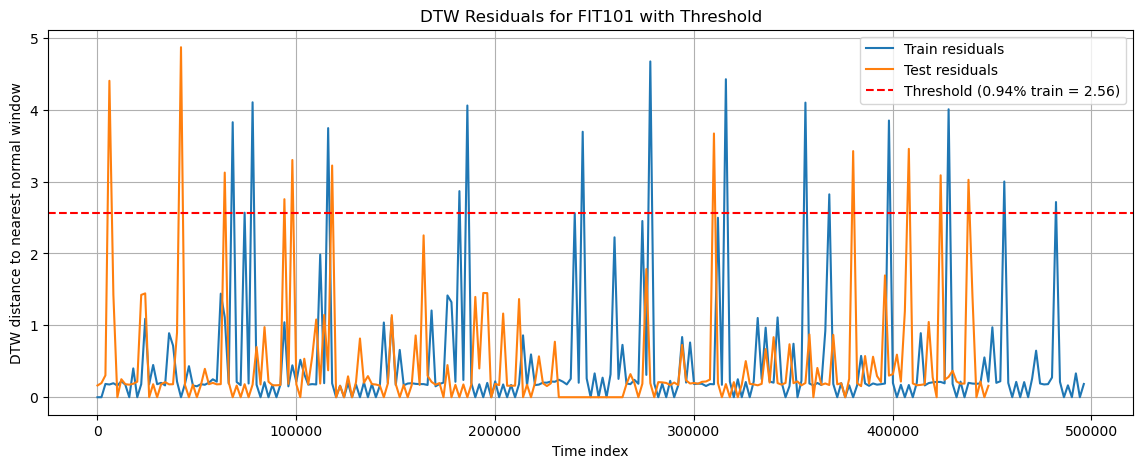

In [218]:
run_dtw_experiment(
    fit101_train, fit101_test,
    window_size=400,
    train_stride=50,
    eval_stride=2000,
    n_rep=20,
    quantile=0.94
)

Windows of 400 makes the residuals more noisy. Even during normal periods, the DTW distance often sits between 0.2 and 1, with many moderate peaks.  
This configuration is more sensitive, but at the cost of a higher false positive rate, since many peaks do not correspond to clearly abnormal behaviour.
The window wise is not large enough and does not capture the anomoly between 22_000 and 27_000 in the test set. 

**STILL**  
This approaches were good but can not mimic the real behaviour of the system, since they do not capture one full cycle.  
None of the tree windows caught the clear anomaly between 22_000 and 27_000, because there are to small and most likely there are representative windows that perfectly mimic the moment when all the points all low, like in the anomaly.   
That is why we will implement subsampling, a tehnique that remove most of the points for computatility power, but which still preserves the shape of the signal.  
In this way, we can make a window to represent one full cycle. 

We want to take one in 10 points, which is a good choice becuase the points are close to each other and this still preserves the shape 

In [18]:
SUBSAMPLE_STEP = 10
fit101_train_sub = fit101_train[::SUBSAMPLE_STEP]
fit101_test_sub = fit101_test[::SUBSAMPLE_STEP]

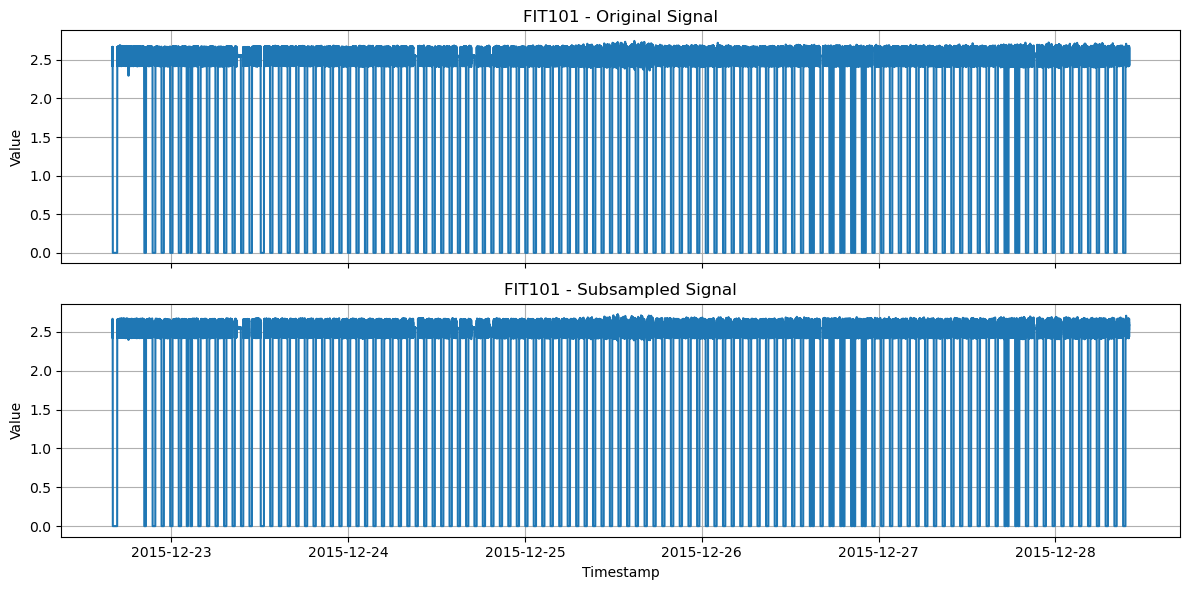

In [19]:
idx_sub = np.arange(0, len(train_data), SUBSAMPLE_STEP)

ts_full = train_data['Timestamp']
fit_full = train_data['FIT101'].values

ts_sub = train_data['Timestamp'].iloc[idx_sub]
fit_sub = fit_full[idx_sub]

_, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(ts_full, fit_full)
axes[0].set_title("FIT101 - Original Signal")
axes[0].set_ylabel("Value")
axes[0].grid(True)

axes[1].plot(ts_sub, fit_sub)
axes[1].set_title("FIT101 - Subsampled Signal")
axes[1].set_xlabel("Timestamp")
axes[1].set_ylabel("Value")
axes[1].grid(True)

plt.tight_layout()
plt.show()


As you can see, the new plot of the sensor has exactly the same shape like the origianl data and also the same behaviour

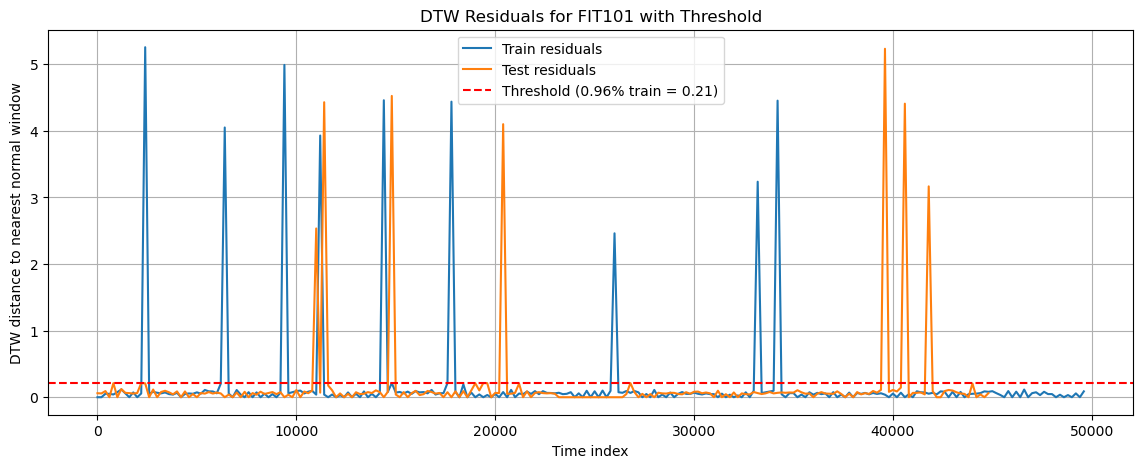

In [20]:
run_dtw_experiment(
    fit101_train_sub, fit101_test_sub,
    window_size=100//SUBSAMPLE_STEP,
    train_stride=50//SUBSAMPLE_STEP,
    eval_stride=2000//SUBSAMPLE_STEP,
    n_rep=20,
    quantile=0.96,
)

The plot for the DTW residuls from earlyer with window sized of 100 points looks exactly the same too. (and now runs in 1 second rather than 5 minutes)

In [21]:
def run_dtw_experiment(fit_train, fit_test,
                       window_size, train_stride, eval_stride,
                       n_rep=20, quantile=0.95,
                       subsample_step=1):

    train_windows_exp = build_windows(fit_train, window_size, train_stride)
    rep_windows_exp = pick_representatives(train_windows_exp, n_rep)

    train_eval_exp, train_centers_exp = build_eval_windows(fit_train, window_size, eval_stride)
    test_eval_exp, test_centers_exp = build_eval_windows(fit_test, window_size, eval_stride)

    train_res_exp = compute_dtw_residuals(train_eval_exp, rep_windows_exp)
    test_res_exp = compute_dtw_residuals(test_eval_exp,  rep_windows_exp)

    train_centers_orig = train_centers_exp * subsample_step
    test_centers_orig = test_centers_exp * subsample_step

    plot_residuals(train_centers_orig, train_res_exp, test_centers_orig, test_res_exp, quantile)

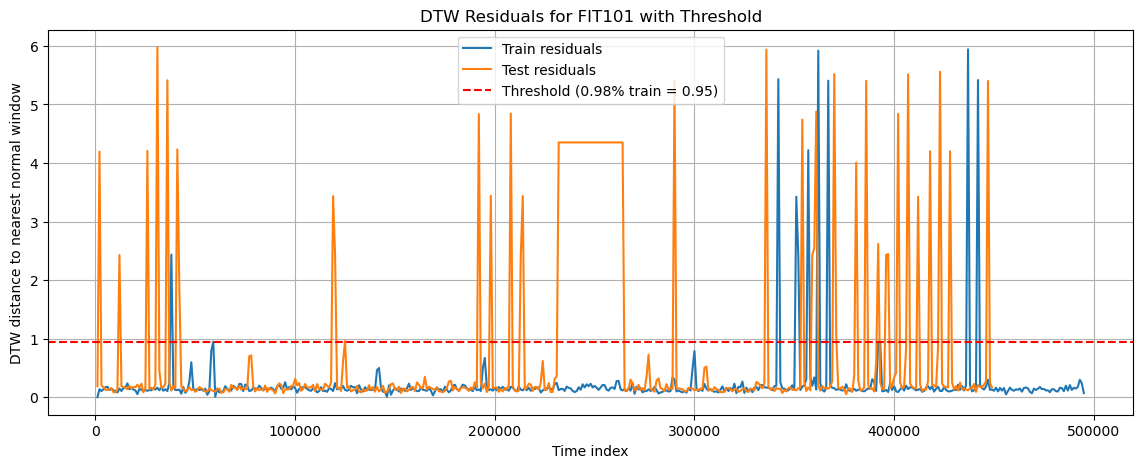

In [22]:
SUBSAMPLE_STEP = 100

fit101_train_sub = fit101_train[::SUBSAMPLE_STEP]
fit101_test_sub = fit101_test[::SUBSAMPLE_STEP]

run_dtw_experiment(
    fit101_train_sub, fit101_test_sub,          # We need to divide by SUBSAMPLE_STEP because a point that is represented in:  
    window_size=2000//SUBSAMPLE_STEP,           # subsampled indices 20 ~ original indices on the position 20*100 = 2000                                        
    train_stride=300//SUBSAMPLE_STEP,          
    eval_stride=1000//SUBSAMPLE_STEP,
    n_rep=100,
    quantile=0.98,
    subsample_step=SUBSAMPLE_STEP
)

After applying subsampling before DTW, the anomaly detection performance improved significantly.  
Because the subsampled windows now capture an entire FIT101 cycle, the DTW distance becomes much more sensitive to changes in the cycle shape.  
We can now clearly see that the long abnormal region between index 22_000 and 27_000 is correctly flagged as anomalous.  

In [23]:
def dtw_signal_overview(full_test_signal,
                        fit_train_sub,
                        fit_test_sub,
                        window_size,
                        train_stride,
                        eval_stride,
                        n_rep,
                        quantile,
                        subsample_step):

    train_windows = build_windows(fit_train_sub, window_size, train_stride)
    rep_windows = pick_representatives(train_windows, n_rep)

    train_eval, _ = build_eval_windows(fit_train_sub, window_size, eval_stride)
    test_eval, test_centers_sub = build_eval_windows(fit_test_sub, window_size, eval_stride)

    train_res = compute_dtw_residuals(train_eval, rep_windows)
    test_res = compute_dtw_residuals(test_eval, rep_windows)

    test_centers = test_centers_sub * subsample_step

    plot_signal_and_residuals(
        test_signal=full_test_signal,
        test_centers=test_centers,
        test_residuals=test_res,
        train_residuals=train_res,
        quantile=quantile
    )


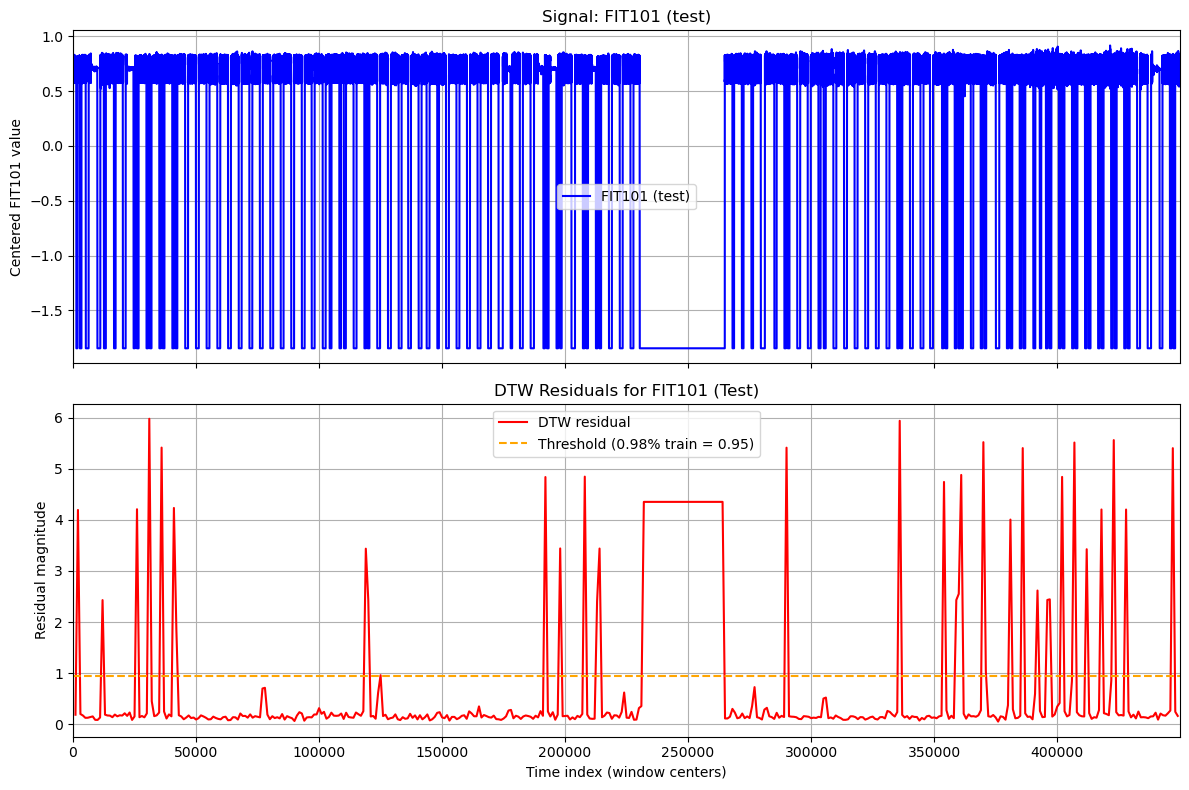

In [55]:
dtw_signal_overview(
    full_test_signal=fit101_test,
    fit_train_sub=fit101_train_sub,
    fit_test_sub=fit101_test_sub,
    window_size=2000//SUBSAMPLE_STEP,
    train_stride=300//SUBSAMPLE_STEP,
    eval_stride =1000//SUBSAMPLE_STEP,
    n_rep=100,
    quantile=0.98,
    subsample_step=SUBSAMPLE_STEP
)

The DTW plot clearly shows that the method now succeeds in detecting the major anomalies in the FIT101 signal.  
The abnormal region in the middle of the test data produces a peak that rises well above the threshold, meaning it correctly flags this large deviation.
In addition, all the sharp, isolated spikes in the signal (the thick drops that can be spotted at 38_000, 43_000) also generate large DTW residuals. These appear in the plot as tall red peaks and are consistently detected as anomalies.

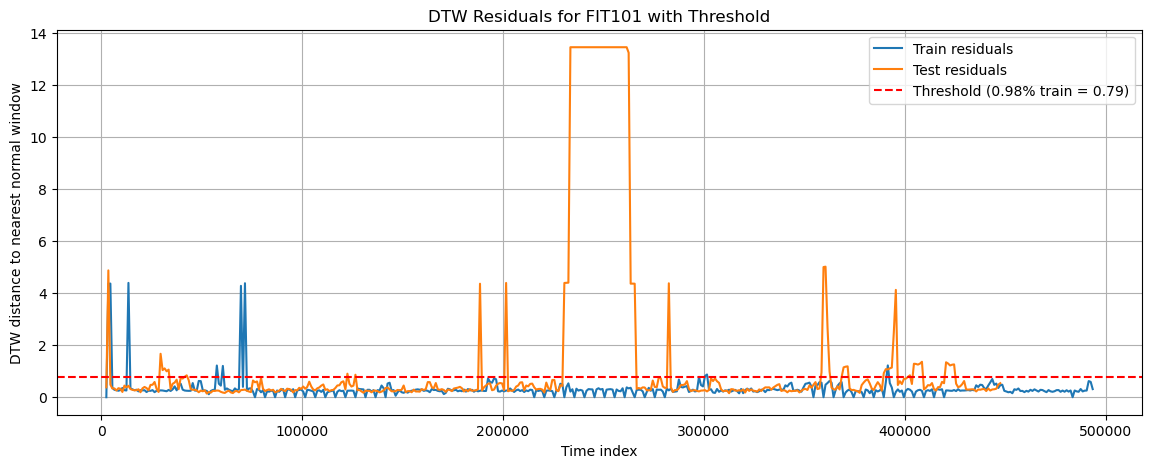

In [25]:
SUBSAMPLE_STEP = 100

fit101_train_sub = fit101_train[::SUBSAMPLE_STEP]
fit101_test_sub = fit101_test[::SUBSAMPLE_STEP]

run_dtw_experiment(
    fit101_train_sub, fit101_test_sub,
    window_size=5000//SUBSAMPLE_STEP,                                      
    train_stride=500//SUBSAMPLE_STEP,           
    eval_stride=1000//SUBSAMPLE_STEP,
    n_rep=100,
    quantile=0.98,
    subsample_step=SUBSAMPLE_STEP
)

The 5000 ponint window now spans seversal cycles at once. Each window contains a mix of normal and abnormal data, thus an anomaly that only occupies a part of the plot is "diluted" by the normal behaviour. Tha's why most of the thick lines between 2000 and 5000 and 35_000 and 50_000 form the teset data are not flagged as anomalies. DTW can also align a large part of the window to normal cycles and this is why the total distance drops. 

Therefore, we think that a window size of 2000 alongside with the other settings for that experiment is the optimal DTW that balances not only the anomaly detection, but also the runtime. 

We really hope you liked our lab!